In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [97]:
df = pd.read_parquet('../data/cleaned/vix.parquet')
df = df.drop(columns=['Volume'])
df

,Date,Close,High,Low,Open,LogRet
0,2005-09-19,12.140000,12.460000,12.04,12.17,NaN
1,2005-09-20,12.640000,12.960000,11.83,12.23,0.040361
2,2005-09-21,13.790000,13.910000,12.96,13.07,0.087077
3,2005-09-22,13.330000,14.390000,13.31,13.85,-0.033927
4,2005-09-23,12.960000,13.880000,12.75,13.64,-0.028149
...,...,...,...,...,...,...
5026,2025-09-11,14.710000,15.240000,14.65,15.19,-0.042588
5027,2025-09-12,14.760000,14.970000,14.41,14.62,0.003393
5028,2025-09-15,15.690000,15.840000,14.92,15.14,0.061103
5029,2025-09-16,16.360001,16.379999,15.44,15.60,0.041816


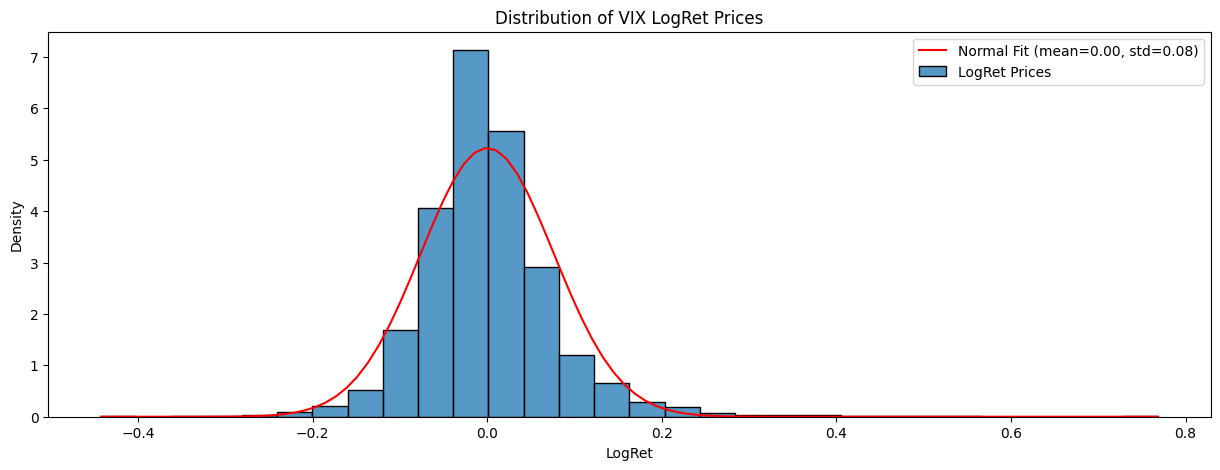

In [98]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt
df.dropna(inplace=True)
# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of VIX LogRet Prices')
plt.legend()
plt.show()

## Stationarity analysis

In [99]:

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

stationarity_analysis(df=df, dataset_name="VIX_raw")
stationarity_analysis(df=df, dataset_name="VIX_log_returns", column_name='LogRet')


STATIONARITY ANALYSIS: VIX_RAW

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -5.657962
p-value: 0.000001
Critical Values:
	1%: -3.431654
	5%: -2.862116
	10%: -2.567077
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 0.555895
p-value: 0.029078
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: NON-STATIONARY (Reject null hypothesis)

--- COMBINED INTERPRETATION ---
CONCLUSION: Results are INCONCLUSIVE - further investigation needed

STATIONARITY ANALYSIS: VIX_LOG_RETURNS

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -28.178470
p-value: 0.000000
Critical Values:
	1%: -3.431653
	5%: -2.862116
	10%: -2.567077
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 0.018648
p-value: 0.100000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: STATIONARY (Fail to reject null hypothesis

In [ ]:
mean_lr = df['LogRet'].mean()
std_lr = df['LogRet'].std()
CLAMP_STD = 2

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['LogRet'] = np.where(df['LogRet'] > upper, upper,
                        np.where(df['LogRet'] < lower, lower, df['LogRet']))


In [101]:

df['LogRet'].mean()- df['LogRet'].std()

np.float64(-0.06670241073580253)

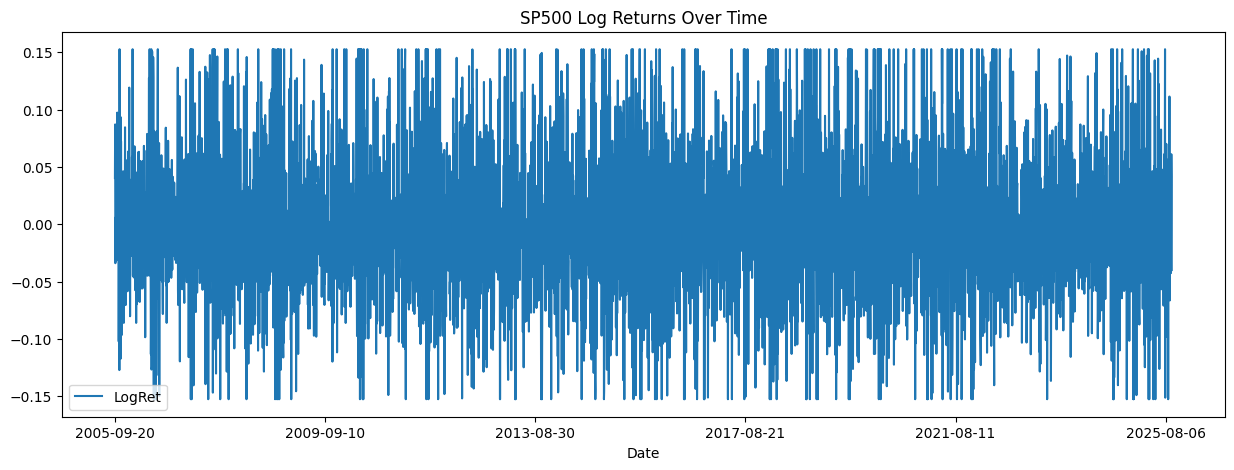

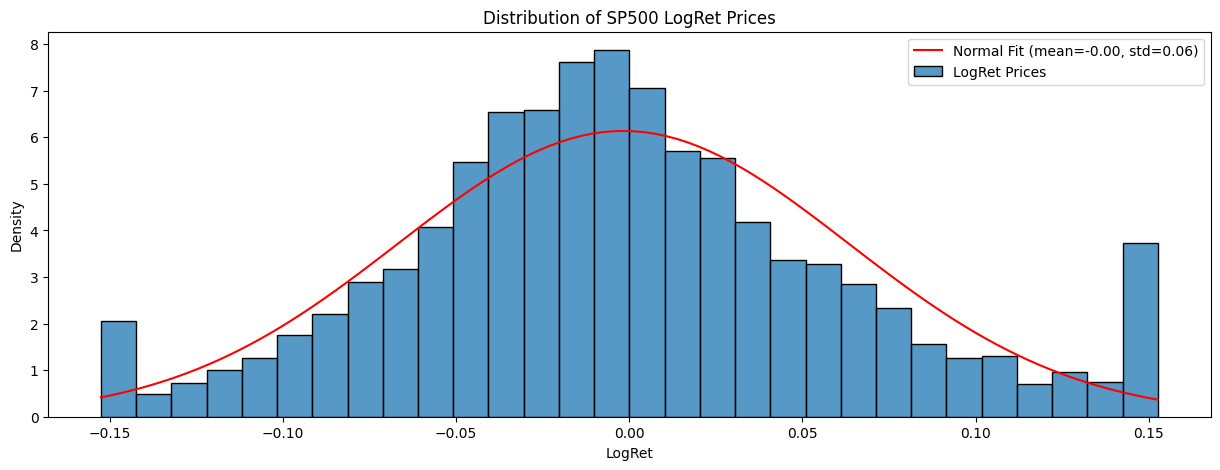

In [102]:
df.plot(x= 'Date', y='LogRet', title='SP500 Log Returns Over Time', figsize=(15,5))

# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of SP500 LogRet Prices')
plt.legend()
plt.show()

In [103]:
# create a collumn calles highlow_range which is the difference between the high and low prices
df['highlow_range'] = df['High'] - df['Low']


In [104]:
cordf = df.drop(columns=['Date']).corr()
# cordf = df.drop(columns=['Date']).corr()
cordf

,Close,High,Low,Open,LogRet,highlow_range
Close,1.000000,0.991054,0.988584,0.981267,0.077890,0.665113
High,0.991054,1.000000,0.983281,0.986016,0.025636,0.724934
Low,0.988584,0.983281,1.000000,0.991820,-0.001441,0.587382
Open,0.981267,0.986016,0.991820,1.000000,-0.055622,0.630480
LogRet,0.077890,0.025636,-0.001441,-0.055622,1.000000,0.119388
highlow_range,0.665113,0.724934,0.587382,0.630480,0.119388,1.000000


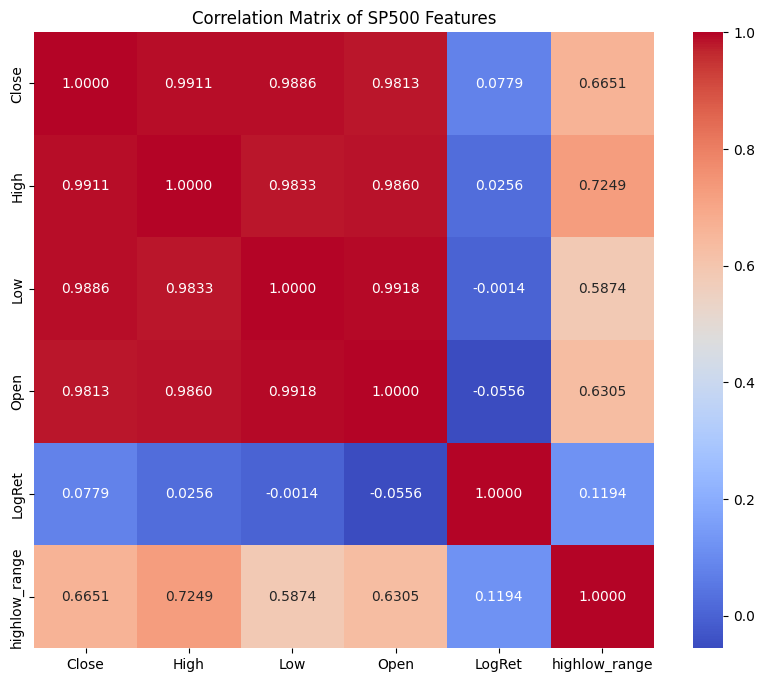

In [105]:
# correlation plot of all the features in the dataframe
plt.figure(figsize=(10, 8))
sns.heatmap(cordf, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of SP500 Features')
plt.show()